In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import re
import seaborn as sns
import numpy as np

### Create functions to calculate biodiversity among random pairs in each file.
- The first function will calculate average genetic diversity in the file.
- The second function will produce a table with individual diversity counts for each random pair.
- The number of random pairs is given by the number of individual in the sample / 2 

In [30]:
# Creating a function to calculate genetic diversity among pairs
# I will use this one to calculate the average diversity of the sample
def average_diversity_simulation(genomes, num_pairs):
    # Select random pairs of indices
    random_indices = random.sample(range(len(genomes)), 2 * num_pairs)

    # Initialize a counter for differences
    differences_count = 0

    # Compare strings in random pairs
    for i in range(0, len(random_indices), 2):
        index1, index2 = random_indices[i], random_indices[i + 1]
        string1, string2 = genomes.iloc[index1], genomes.iloc[index2]

        # Compare strings and count differences
        differences_count = differences_count + sum(c1 != c2 for c1, c2 in zip(string1, string2))

    # Calculate the average differences per pair
    average_differences = differences_count / num_pairs

    return average_differences

# Creating a function to create and store diversity values and return them in a table, 
# from this table we will calculate stasts for each sample
def diversity_table(genomes, num_pairs):
    # Select random pairs of indices
    random_indices = random.sample(range(len(genomes)), 2 * num_pairs)

    # Initialize a counter for differences
    differences_list = []

    # Compare strings in random pairs
    for i in range(0, len(random_indices), 2):
        index1, index2 = random_indices[i], random_indices[i + 1]
        string1, string2 = genomes.iloc[index1], genomes.iloc[index2]

        # Compare strings and count differences
        differences_count = sum(c1 != c2 for c1, c2 in zip(string1, string2))

        # Append to the list
        differences_list.append((differences_count))

    return differences_list


### Folders
Define the list of folders where I have stored all of my results (each environment file has a folder)

In [ ]:
# List of folder paths
folder_paths = ['/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/1over5/mh',
                '/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/1over10/mh',
                '/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/1over25/mh',
                '/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/1over50/mh',
                '/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/1over100/mh',
                '/Users/gb4818/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Rev-res-in/1over200/mh']

# Define folder labels
folder_labels = ['w=5', 'w=10', 'w=25', 'w=50', 'w=100', 'w=200']


### Median Diversity - individual sim
Create plots with median diversity at equilibrium for each simulation

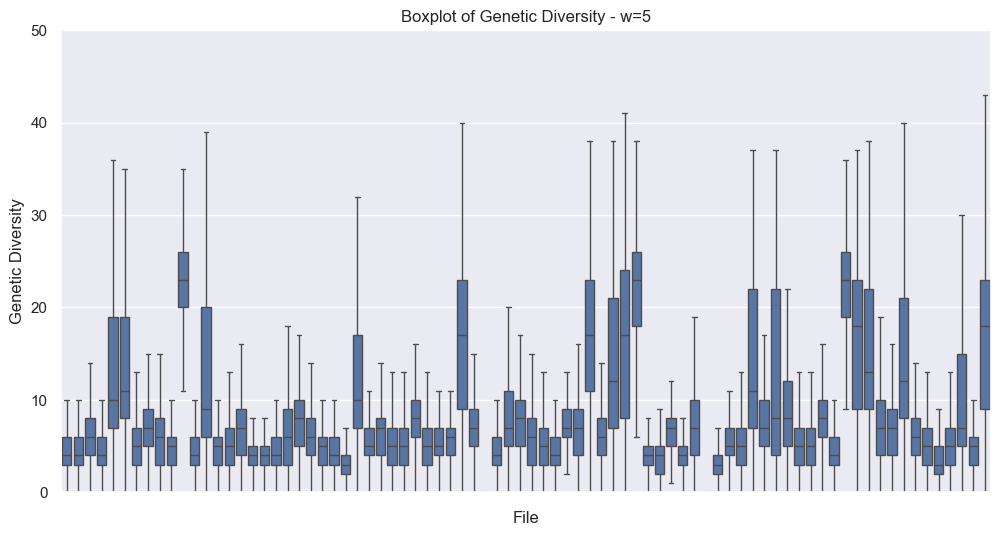

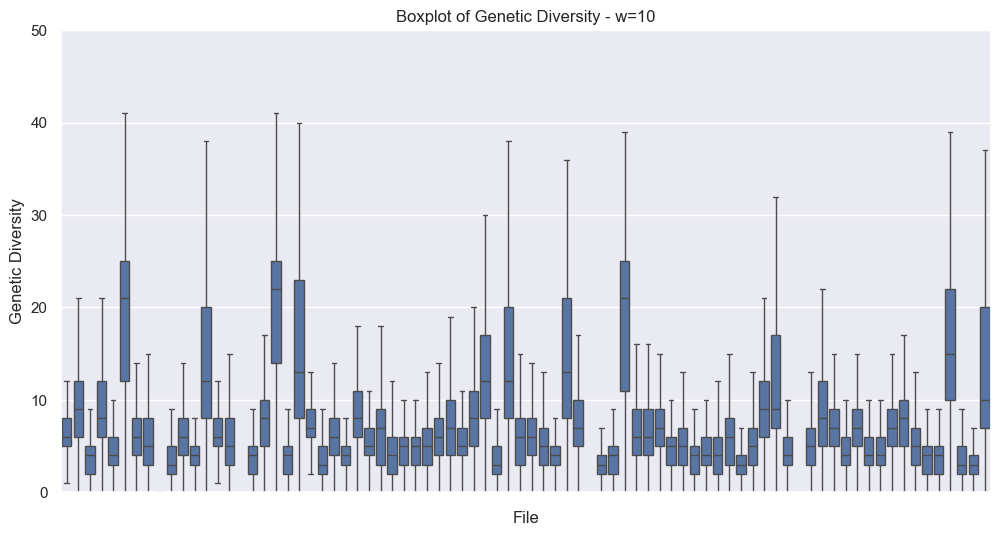

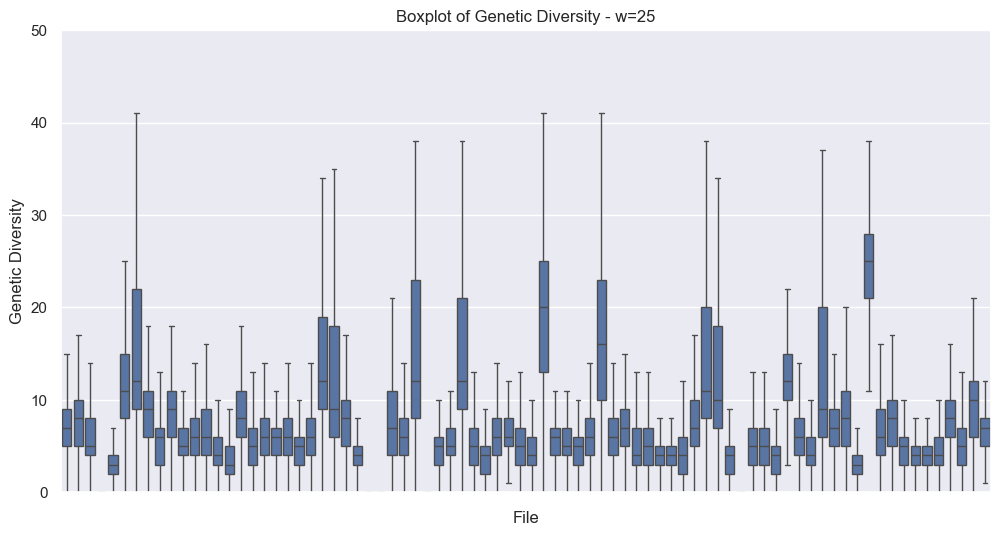

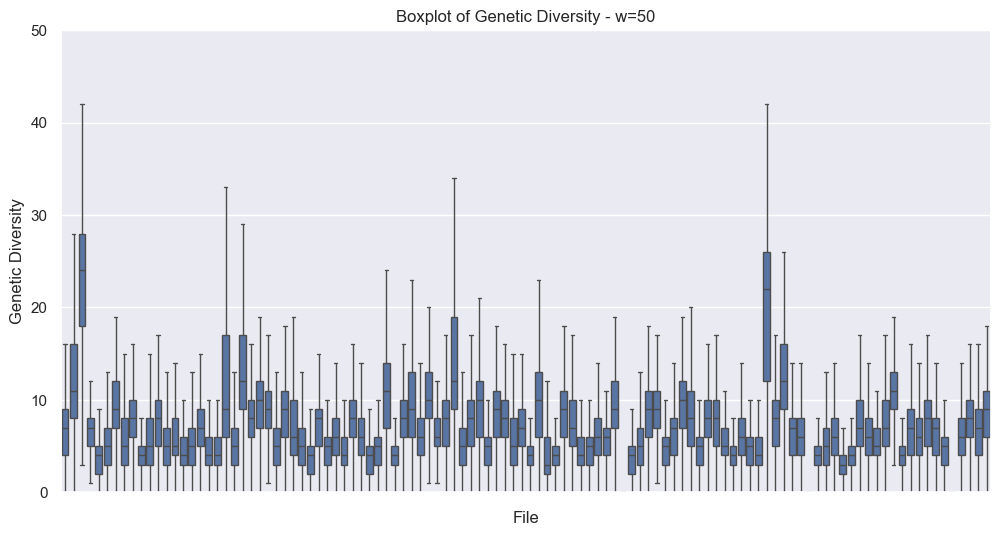

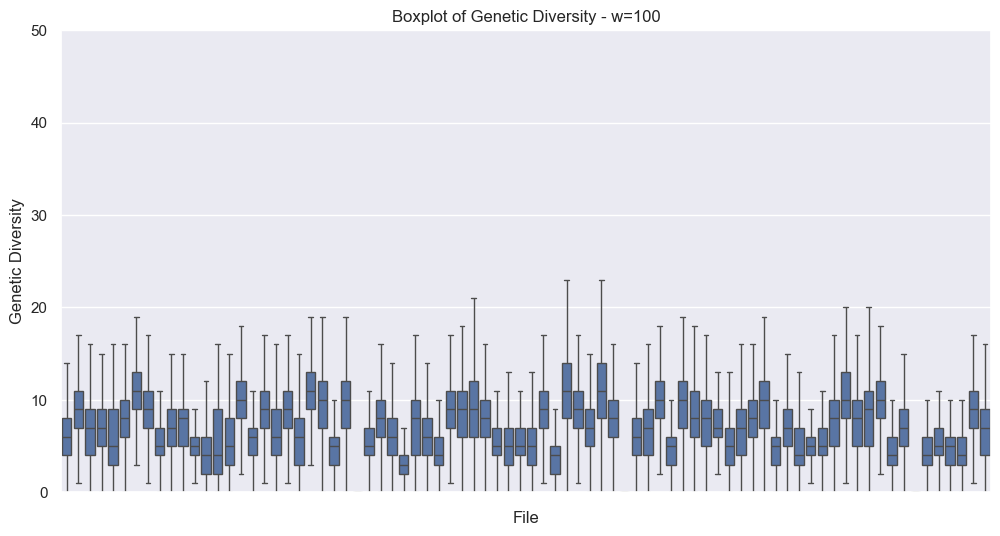

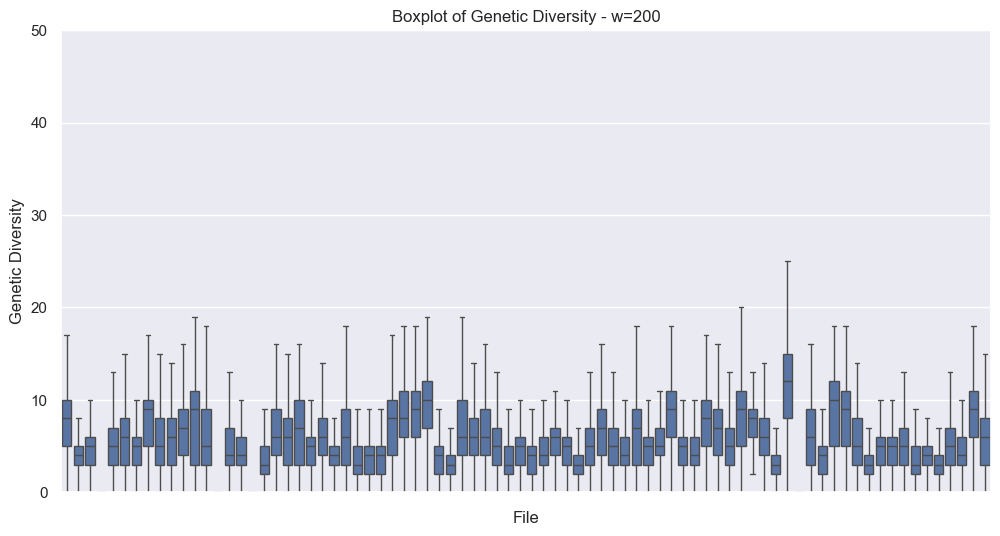

In [99]:
# Create a list to store all the DataFrames
all_dfs = []

# Loop through each folder
for folder_path, folder_label in zip(folder_paths, folder_labels):
    # Create a list to store all the DataFrames for the current folder
    dfs = []

    # Loop through each file in the directory
    for filename in os.listdir(folder_path):
        match = re.match(r'REvoSim_individuals_data_(\d+).txt', filename)
        if match:
            file_path = os.path.join(folder_path, filename)

            # Read the DataFrame from the file
            df = pd.read_csv(file_path, sep=',', header=0, skiprows=12)
            genomes = df['Genome']

            # Calculate genetic diversity and store in the list
            diversity_list = diversity_table(genomes, len(genomes) // 2)

            # Create a DataFrame with an additional 'File' column
            div_df = pd.DataFrame({'Diversity': diversity_list, 'File': [filename] * len(diversity_list)})
            dfs.append(div_df)

    # Combine all DataFrames for the current folder into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)
    all_dfs.append(combined_df)

# Create a boxplot for each folder
for combined_df, folder_label in zip(all_dfs, folder_labels):
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(y='Diversity', x='File', data=combined_df, flierprops=dict(markersize=0))
    ax.set_xticklabels([])  # Hide x-axis labels
    plt.title(f'Boxplot of Genetic Diversity - {folder_label}')
    plt.ylabel('Genetic Diversity')
    plt.ylim(0, 50)  # Set y-axis limits
    plt.show()



### Average Diversity - Environments
How each environment performed if we look at the average diversity of each file. 

In [97]:
# Initialize an empty list to store dictionaries
results_list = []

for i, folder_path in enumerate(folder_paths):
    # Loop through files in the folder
    for filename in os.listdir(folder_path):
        match = re.match(r'REvoSim_individuals_data_(\d+).txt', filename)
        if match:
            file_path = os.path.join(folder_path, filename)
            
            # import data 
            df = pd.read_csv(file_path, sep=',', header=0, skiprows=12)
            genomes = df['Genome']
          
            # Calculate average differences for the current file
            diversity = average_diversity_simulation(genomes, len(genomes)//2)

            # Append dictionary to the list
            result_dict = {'File': filename, 'Folder': folder_labels[i], 'AverageDiversity': diversity, 'Pairs':len(genomes)//2}
            results_list.append(result_dict)

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results_list)
mean_div_env = results_df.groupby('Folder')['AverageDiversity'].mean().reset_index()

/var/folders/dm/ryjvp3j51h78gsbgf92k6xvh0000gp/T/ipykernel_32191/2294222545.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Folder', y='AverageDiversity', data=results_df, alpha=0.5, palette='viridis')


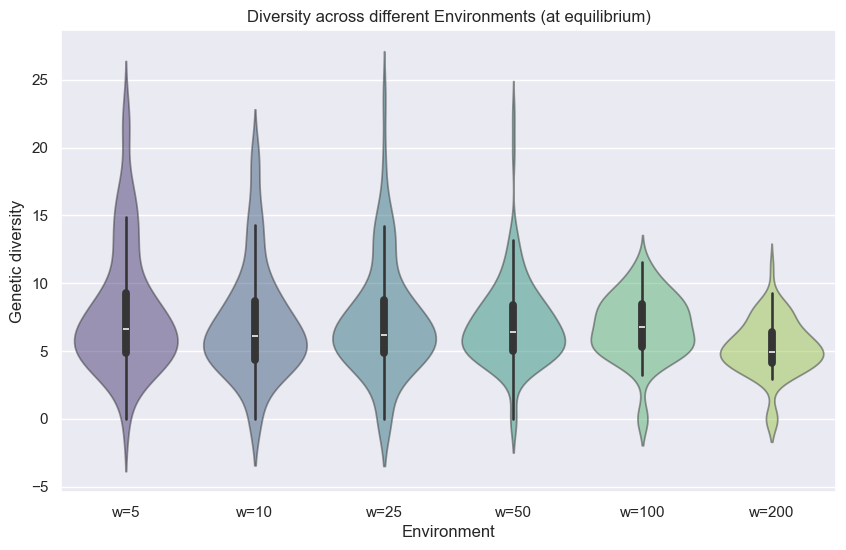

In [98]:
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Folder', y='AverageDiversity', data=results_df, alpha=0.5, palette='viridis')

# Labels
plt.xlabel('Environment')
plt.ylabel('Genetic diversity')
plt.title('Diversity across different Environments (at equilibrium)')
plt.show()

## Shannon index calculation

In [6]:
# I want to compare this genetic diversity and compare it to the community structure, basically I want to see the abbundance of each species
# Initialize an empty list to store results
shannon_results = []

for i, folder_path in enumerate(folder_paths):
    # Initialize an empty list to store Shannon Diversity Index for each file in the folder
    shannon_values = []

for i, folder_path in enumerate(folder_paths):
    # Loop through files in the folder
    for filename in os.listdir(folder_path):
        match = re.match(r'REvoSim_individuals_data_(\d+).txt', filename)
        if match:
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path, sep=',', header=0, skiprows=12)
            
            # Calculate species proportions
            species_counts = df['species ID'].value_counts()
            total_individuals = species_counts.sum()
            proportions = species_counts / total_individuals
            
            # Calculate Shannon Diversity Index
            shannon_index = -np.sum(proportions * np.log2(proportions))
            
            # Append results to the list
            shannon_values.append(shannon_index)
    
    # Calculate the mean Shannon Diversity Index for the folder
    mean_shannon = np.mean(shannon_values)
    
    # Append results to the final list
    shannon_results.append({
        'folder_label': folder_labels[i],
        'mean_shannon_index': mean_shannon
    })

# Display the results
for result in shannon_results:
    print(f"Folder Label: {result['folder_label']}")
    print(f"Mean Shannon Diversity Index: {result['mean_shannon_index']}")
    print("=" * 50)

            

Folder Label: w=5
Mean Shannon Diversity Index: 1.1877160027384526
Folder Label: w=10
Mean Shannon Diversity Index: 1.021106714464521
Folder Label: w=25
Mean Shannon Diversity Index: 0.9403800132090628
Folder Label: w=50
Mean Shannon Diversity Index: 0.8326558292541544
Folder Label: w=100
Mean Shannon Diversity Index: 0.6851847749779476
Folder Label: w=200
Mean Shannon Diversity Index: 0.6396786101346922


## Species Diversity Curves
### Getting some random simulation and looking at the Diversity curves (species ranked by abundance of individuals)

In [95]:
# Initialize an empty DataFrame to store results
result_table = pd.DataFrame()

for i, folder_path in enumerate(folder_paths):
    # Get a list of files in the folder
    files_in_folder = [filename for filename in os.listdir(folder_path) if re.match(r'REvoSim_individuals_data_(\d+).txt', filename)]
    
    # Randomly select one file
    selected_file = np.random.choice(files_in_folder)
    file_path = os.path.join(folder_path, selected_file)
    
    # Read the DataFrame from the selected file
    df = pd.read_csv(file_path, sep=',', header=0, skiprows=12)
    
    # Calculate species counts
    species_counts = df['species ID'].value_counts().reset_index()
    
    # Rename columns for clarity
    species_counts.columns = ['Species ID', 'Count']
    
    # Add a column for the folder label
    species_counts['Folder Label'] = folder_labels[i]
    
    # Append results to the final table
    result_table = pd.concat([result_table, species_counts], ignore_index=True)

# Display the resulting table
print(result_table)


     Species ID   Count Folder Label
0             1  190720          w=5
1           297     260          w=5
2           277     194          w=5
3           174     182          w=5
4           139     116          w=5
..          ...     ...          ...
271         251      23        w=100
272         191      21        w=100
273         242      20        w=100
274           1  170808        w=200
275          22   23323        w=200

[276 rows x 3 columns]


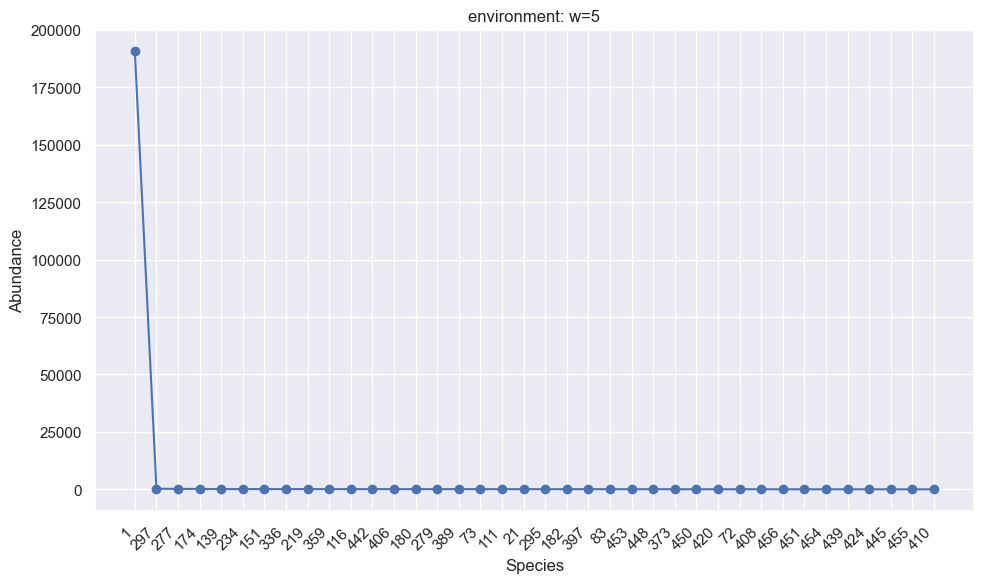

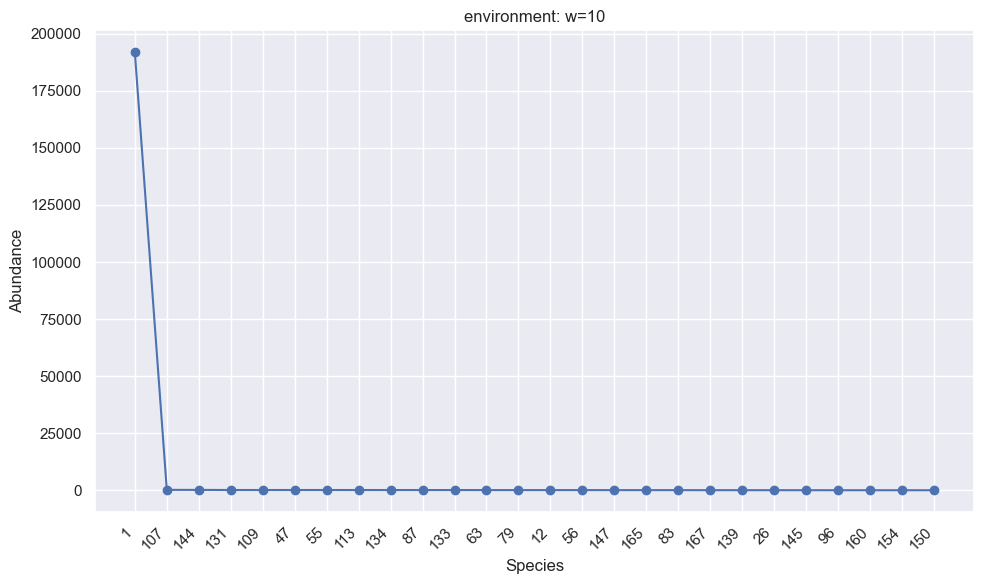

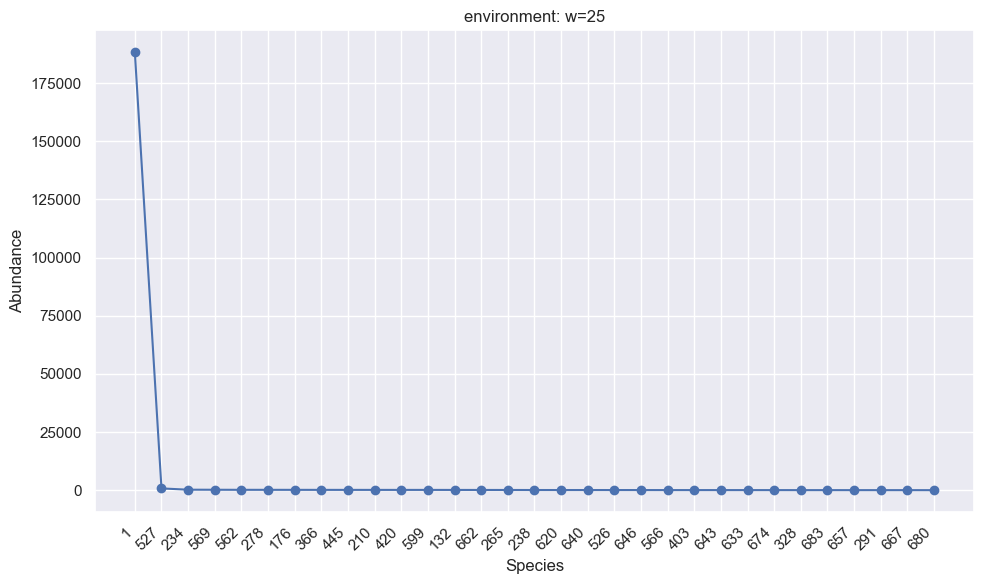

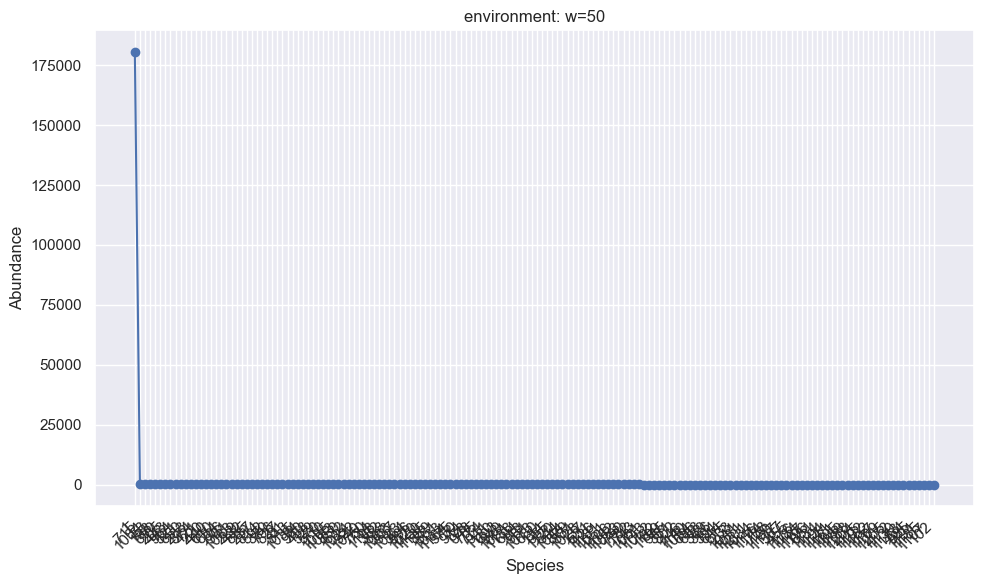

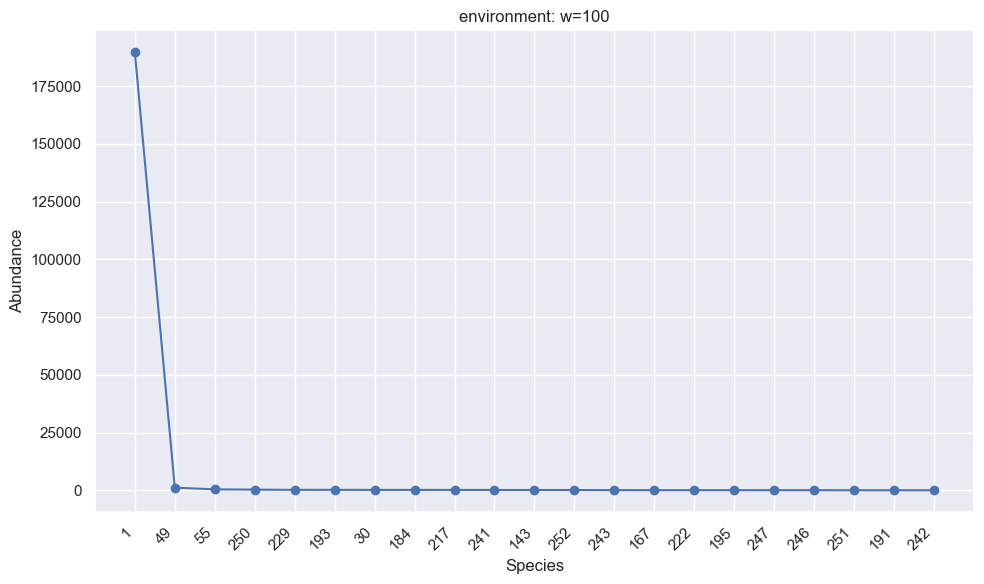

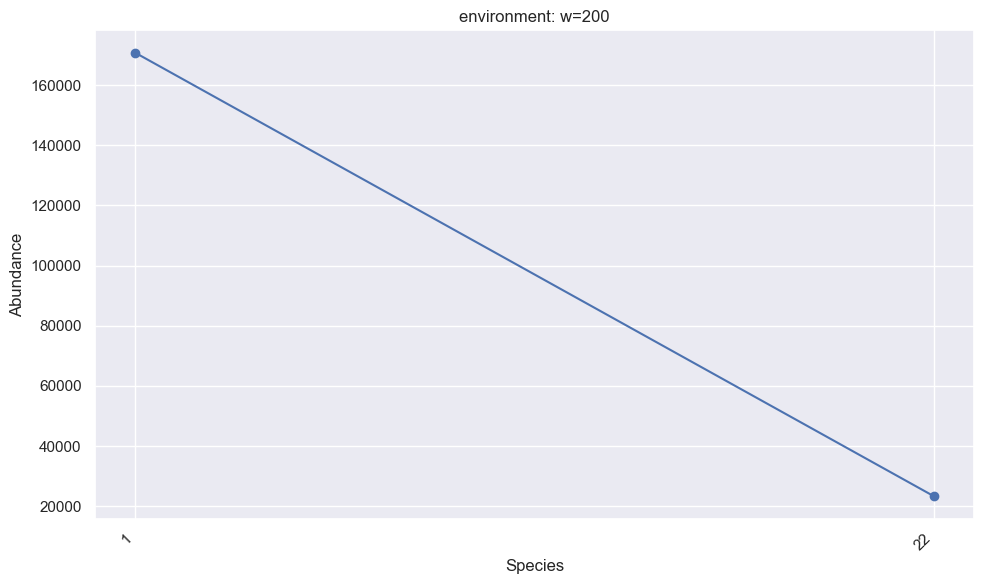

In [96]:
#creating an abundance rank curve for these random samples I have taken:
for env in result_table['Folder Label'].unique():
    # Filter data for the current location
    env_data = result_table[result_table['Folder Label'] == env]

    # Sort data by abundance in descending order
    env_data = env_data.sort_values(by='Count', ascending=False)
    env_data['Species ID'] = env_data["Species ID"].astype(str)

    # Create a scatter plot with a line connecting the dots
    plt.figure(figsize=(10, 6))
    plt.plot(env_data['Species ID'], env_data['Count'], marker='o', linestyle='-', color='b')

    # Set labels and title
    plt.xlabel('Species')
    plt.ylabel('Abundance')
    plt.title(f'environment: {env}')

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()
    plt.show()
 